# Invert three surveys line for a thin plate

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em_three_lines_transmitters.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/airborne_em

In [2]:
import numpy
import matplotlib.pyplot as plt
import cofi

from forward_lib import (
    problem_setup, 
    system_spec, 
    survey_setup, 
    ForwardWrapper, 
    plot_predicted_profile, 
    plot_transient, 
    plot_plate_faces, 
    plot_plate_faces_single
)

numpy.random.seed(42)

# Background

This example inverts a three survey line of VTEM max data using the vertical  component for a thin plate target. It thus becomes possible to invert for the easting,northing, depth of the palte reference point, the plate dip and plate azimuth and the plate length.

## Problem definition

In [4]:
tx_min = 115
tx_max = 281
tx_interval = 15
ty_min = 25
ty_max = 176
ty_interval = 75
tx_points = numpy.arange(tx_min, tx_max, tx_interval)
ty_points = numpy.arange(ty_min, ty_max, ty_interval)
n_transmitters = len(tx_points) * len(ty_points)
tx, ty = numpy.meshgrid(tx_points, ty_points)
tx = tx.flatten()
ty = ty.flatten()

In [5]:
fiducial_id = numpy.arange(len(tx))
line_id = numpy.zeros(len(tx), dtype=int)
line_id[ty==ty_points[0]] = 0
line_id[ty==ty_points[1]] = 1
line_id[ty==ty_points[2]] = 2

In [6]:
survey_setup = {
    "tx": tx,                                                   # transmitter easting/x-position
    "ty": ty,                                                   # transmitter northing/y-position
    "tz": numpy.array([50]*n_transmitters),                     # transmitter height/z-position
    "tazi": numpy.deg2rad(numpy.array([90]*n_transmitters)),    # transmitter azimuth
    "tincl": numpy.deg2rad(numpy.array([6]*n_transmitters)),    # transmitter inclination
    "rx": tx,                                                   # receiver easting/x-position
    "ry": numpy.array([100]*n_transmitters),                    # receiver northing/y-position
    "rz": numpy.array([50]*n_transmitters),                     # receiver height/z-position
    "trdx": numpy.array([0]*n_transmitters),                    # transmitter receiver separation inline
    "trdy": numpy.array([0]*n_transmitters),                    # transmitter receiver separation crossline
    "trdz": numpy.array([0]*n_transmitters),                    # transmitter receiver separation vertical
    "fiducial_id": fiducial_id,                                 # unique id for each transmitter
    "line_id": line_id                  # id for each line
}

In [7]:
true_model = {
    "res": numpy.array([300, 1000]), 
    "thk": numpy.array([20]), 
    "peast": numpy.array([175]), 
    "pnorth": numpy.array([100]), 
    "ptop": numpy.array([30]), 
    "pres": numpy.array([0.1]), 
    "plngth1": numpy.array([100]), 
    "plngth2": numpy.array([100]), 
    "pwdth1": numpy.array([0.1]), 
    "pwdth2": numpy.array([90]), 
    "pdzm": numpy.array([75]),
    "pdip": numpy.array([60])
}

In [8]:
forward = ForwardWrapper(true_model, problem_setup, system_spec, survey_setup,
                         ["pdip","pdzm", "peast", "ptop", "pwdth2"], data_returned=["vertical"])

['pdip', 'pdzm', 'peast', 'ptop', 'pwdth2']


In [9]:
# check the order of parameters in a model vector
forward.params_to_invert

['pdip', 'pdzm', 'peast', 'ptop', 'pwdth2']

In [10]:
true_param_value = numpy.array([60,65, 175, 30, 90])

**Generate synthetic data**

In [11]:
data_noise = 0.01
data_pred_true = forward(true_param_value)
data_obs = data_pred_true + numpy.random.normal(0, data_noise, data_pred_true.shape)

## Optimisation

**Initialise a model for inversion**

In [12]:
init_param_value = numpy.array([45, 90, 150, 20, 80])

**Define helper functions for inversion**

In [13]:
def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ residual

def my_gradient(model):
    dpred = forward(model)
    jacobian = forward.jacobian(model)
    residual = dpred - data_obs
    return 2 * jacobian.T @ residual

def my_hessian(model):
    jacobian = forward.jacobian(model)
    return 2 * jacobian.T @ jacobian

class CallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        print(f"  objective value: {my_problem.objective(xk)}")
        self.x = xk
        self.i += 1

**Define CoFI problem**

In [14]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)
my_problem.set_gradient(my_gradient)
my_problem.set_hessian(my_hessian)
my_problem.set_initial_model(init_param_value)

**Define CoFI options**

In [17]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="Newton-CG",callback=CallbackFunction())

**Define CoFI inversion**

In [18]:
my_inversion = cofi.Inversion(my_problem, my_options)
my_result = my_inversion.run()
print(my_result.model)

Iteration #1
  objective value: 50.128190705851225
Iteration #2
  objective value: 16.36625588194012
Iteration #3
  objective value: 4.088341626240256
Iteration #4
  objective value: 2.4759211270426356
Iteration #5
  objective value: 1.4872572626635874
Iteration #6
  objective value: 1.4266652384212173
Iteration #7
  objective value: 1.389490729069898
Iteration #8
  objective value: 1.3364477864646491
Iteration #9
  objective value: 1.3212793573110704
[ 61.08966046  65.59415252 176.36815503  19.9999997   85.54021046]


## Plotting

**Plotting the data**

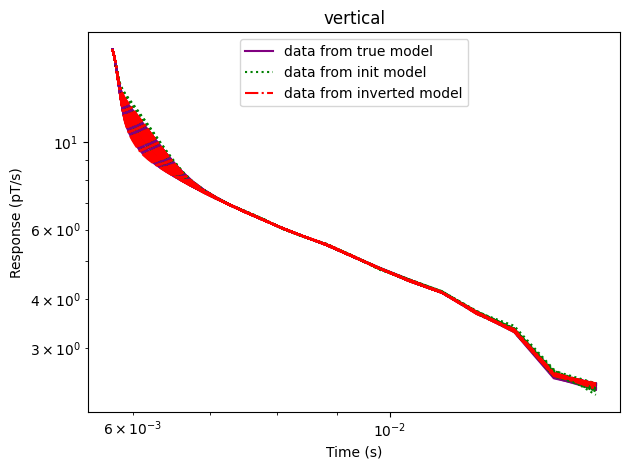

In [21]:
_, ax = plt.subplots()
plot_transient(true_param_value, forward, "data from true model", ax, color="purple")
plot_transient(init_param_value, forward, "data from init model", ax, color="green", linestyle=":")
plot_transient(my_result.model, forward, "data from inverted model", ax, color="red", linestyle="-.")
ax.legend(loc="upper center")
ax.set_title("vertical")
plt.tight_layout()

NameError: name 'true_param_value' is not defined

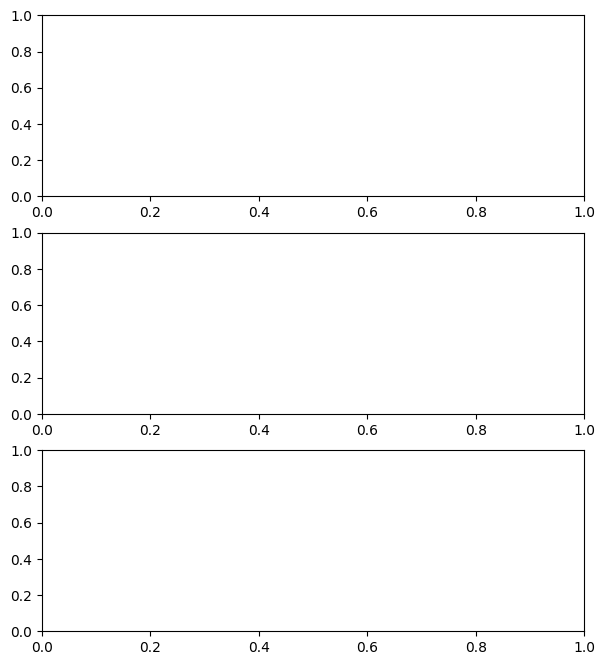

In [3]:
idx_to_plot = numpy.arange(8, 30)       # (0, 44)

_, axes = plt.subplots(3, 1, figsize=(7,8))

for i in range(3):
    plot_predicted_profile(true_param_value, forward, "data from true model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="purple")
    plot_predicted_profile(init_param_value, forward, "data from init model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="green", linestyle=":")
    plot_predicted_profile(my_result.model, forward, "data from inverted model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="red", linestyle="-.")
    axes[i].legend(bbox_to_anchor=(1.04, 0), loc="lower left")
plt.tight_layout()

**Plotting the model**

 As a general rule we can only constrain apretmers if there are fidcuails in the survey that are sesnitvie to it and also fiducails that are not sensitivie to it. in order words the anomly needs to be closed withr espect ot the modle apratmer in question. So to be able to constraint plate lenght we would need survey lines to the north and south that are not overflyinh the plate.

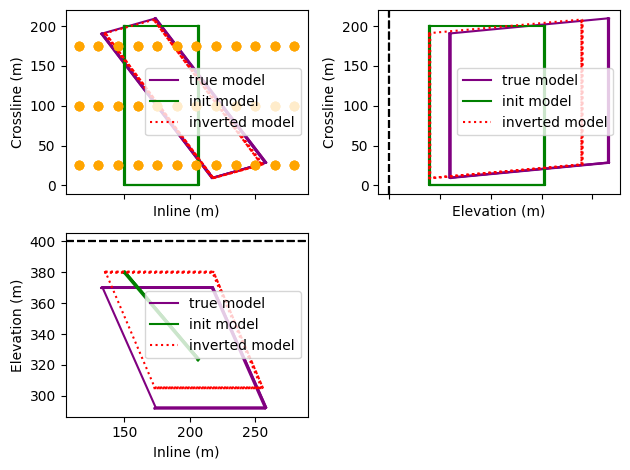

In [23]:
_, axes = plt.subplots(2, 2, sharex="col")
axes[1,1].axis("off")
plot_plate_faces(
    "plate_true", forward, true_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="purple", label="true model"
)
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="init model"
)
plot_plate_faces(
    "plate_inverted", forward, my_result.model, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="inverted model", linestyle="dotted"
)

plt.tight_layout()

point = Line2D([0], [0], label='Fiducial', marker='o', markersize=5, 
         markeredgecolor='orange', markerfacecolor='orange', linestyle='')

handles, labels = axes[1,0].get_legend_handles_labels()
handles.extend([point])

axes[1,0].legend(handles=handles,bbox_to_anchor=(1.04, 0), loc="lower left")

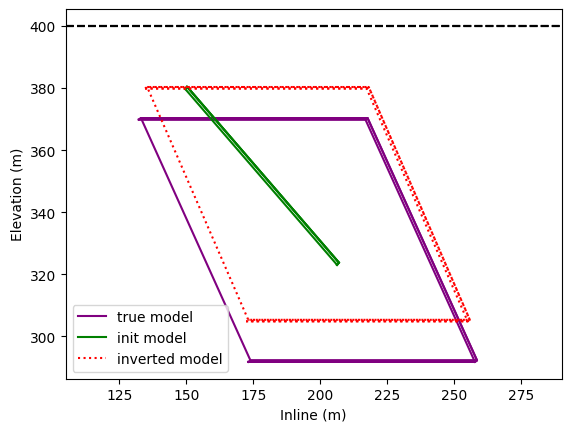

In [24]:
_, ax = plt.subplots(1, 1)
plot_plate_faces_single("plate_true", "xz", forward, true_param_value, ax, color="purple", label="true model")
plot_plate_faces_single("plate_init", "xz", forward, init_param_value, ax, color="green", label="init model")
plot_plate_faces_single("plate_inverted", "xz", forward, my_result.model, ax, color="red", label="inverted model", linestyle="dotted")
ax.legend();

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [ ]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))